
# Stage 2 — Clustering (KMeans, Agglomerative, DBSCAN)

**Goal:** Discover structure in the real-estate listings using multiple clustering algorithms and compare their results and quality.  
**Why clustering?** Grouping similar listings can surface *market segments* (e.g., compact urban studios vs. large family apartments), inform pricing strategies, and guide downstream tasks like recommendation or anomaly detection.

**Algorithms (≥ 3; includes hierarchical):**
- **KMeans** — efficient centroid-based clustering.
- **Agglomerative (Hierarchical)** — builds a cluster tree; we’ll visualize a dendrogram.
- **DBSCAN** — density-based; can detect arbitrarily-shaped clusters + identify noise.

> Throughout, we:
> - Standardize features to stabilize distance-based algorithms.
> - Include engineered features and optional text **embedding PCA** features to add semantic signal.
> - Use multiple validity indices: **Silhouette**, **Davies–Bouldin**, **Calinski–Harabasz**.
> - Profile clusters to interpret what makes each group distinct.



## 0. Configuration
Edit the paths if needed. By default we use your uploaded cleaned file.


In [3]:

from pathlib import Path

# === PATHS ===
DATA_PATH = Path("/Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/clean_realestate.csv")  # change if needed
DATA_FORMAT = "csv"  # "csv" or "parquet"

# Outputs will be written next to the data file by default
OUT_DIR = Path("/Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility / performance
RANDOM_STATE = 42

print("Using:", DATA_PATH.resolve())
print("Will save outputs to:", OUT_DIR.resolve())


Using: /Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/clean_realestate.csv
Will save outputs to: /Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data



## 1. Imports & Helper Functions
- **Robust scaling** reduces sensitivity to outliers compared to standardization.
- We add **feature engineering** (price_per_sqm, floor_ratio, etc.) and parse **Ollama embeddings** when available, reducing them via PCA to keep only the dominant semantics.
- Dendrogram plotting uses SciPy's `linkage` for interpretability.


In [4]:

import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram

# ---- Plotting hygiene ----
# Per your course rules: matplotlib only, one chart per figure, default colors.
plt.rcParams.update({"figure.figsize": (8, 5)})

def coerce_numeric(s):
    """Best-effort numeric coercion (handles commas/whitespace)."""
    return pd.to_numeric(
        s.astype(str).str.replace(",", "", regex=False).str.strip(),
        errors="coerce"
    )

def parse_embedding_cell(x):
    """Parse one cell that may be a list or a stringified list of floats."""
    if isinstance(x, (list, np.ndarray)):
        return np.array(x, dtype=float)
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, (list, tuple, np.ndarray)):
                return np.array(val, dtype=float)
        except Exception:
            pass
    return np.nan

def parse_embedding_column(series):
    """Return 2D numpy array (n_samples, dim) or None if unusable."""
    parsed = series.apply(parse_embedding_cell)
    # Filter rows that parsed successfully and align indices
    mask = parsed.apply(lambda v: isinstance(v, np.ndarray))
    if mask.sum() == 0:
        return None, mask
    # Ensure equal dimensions by padding/truncating to the mode length
    lengths = parsed[mask].apply(lambda v: len(v))
    if lengths.empty:
        return None, mask
    dim = lengths.mode().iloc[0]
    def fix_dim(v):
        if not isinstance(v, np.ndarray):
            return np.full(dim, np.nan)
        if len(v) == dim:
            return v
        if len(v) > dim:
            return v[:dim]
        out = np.full(dim, np.nan)
        out[:len(v)] = v
        return out
    emb_matrix = np.stack(parsed.apply(fix_dim).values)
    return emb_matrix, mask

def engineer_features(df):
    """Create numeric features suitable for clustering."""
    df = df.copy()

    # Coerce key numerics
    for col in ["price", "rooms", "floor", "total_floors", "size_sqm"]:
        if col in df.columns:
            df[col] = coerce_numeric(df[col])

    # Feature engineering
    if "size_sqm" in df.columns and "price" in df.columns:
        df["price_per_sqm"] = df["price"] / df["size_sqm"]
    else:
        df["price_per_sqm"] = np.nan

    if "floor" in df.columns and "total_floors" in df.columns:
        df["floor_ratio"] = df["floor"] / df["total_floors"]
        df["is_top_floor"] = (df["floor"] == df["total_floors"]).astype(float)
    else:
        df["floor_ratio"] = np.nan
        df["is_top_floor"] = np.nan

    # Days since published
    if "published_at" in df.columns:
        dt = pd.to_datetime(df["published_at"], errors="coerce", utc=True)
        max_date = pd.Timestamp.utcnow()
        df["days_since_published"] = (max_date - dt).dt.days
    else:
        df["days_since_published"] = np.nan

    # Embedding PCA (optional)
    emb_pca_cols = []
    if "description_embedding" in df.columns:
        emb_matrix, mask = parse_embedding_column(df["description_embedding"])
        if emb_matrix is not None:
            # median impute per-dim for nans introduced by padding/missing
            emb_df = pd.DataFrame(emb_matrix, index=df.index)
            emb_df = emb_df.apply(lambda col: col.fillna(col.median()), axis=0)
            scaler = StandardScaler()
            emb_scaled = scaler.fit_transform(emb_df.values)
            pca = PCA(n_components=min(10, emb_scaled.shape[1]), random_state=RANDOM_STATE)
            emb_pca = pca.fit_transform(emb_scaled)
            for i in range(emb_pca.shape[1]):
                colname = f"emb_pca{i+1}"
                df[colname] = emb_pca[:, i]
                emb_pca_cols.append(colname)

    # Candidate numeric features for clustering
    base_numeric = ["price", "rooms", "size_sqm", "price_per_sqm", "floor_ratio", "is_top_floor", "days_since_published"]
    # Keep only those present
    features = [c for c in base_numeric if c in df.columns]
    # Add embedding PCA if available
    features += emb_pca_cols

    # Impute missing numerics with median (simple, robust for clustering EDA)
    for c in features:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        med = df[c].median()
        df[c] = df[c].fillna(med)

    # Robust scale
    scaler = RobustScaler()
    X = scaler.fit_transform(df[features].values)
    return df, X, features

def quality_indices(X, labels):
    """Compute clustering validity metrics safely (NaN if invalid)."""
    try:
        if len(np.unique(labels)) < 2:
            return np.nan, np.nan, np.nan
        sil = silhouette_score(X, labels, metric="euclidean")
    except Exception:
        sil = np.nan
    try:
        ch = calinski_harabasz_score(X, labels)
    except Exception:
        ch = np.nan
    try:
        db = davies_bouldin_score(X, labels)
    except Exception:
        db = np.nan
    return sil, ch, db

def plot_knee_kdist(X, k=10):
    """k-distance plot for DBSCAN eps heuristic."""
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    dists, _ = nn.kneighbors(X)
    k_dists = np.sort(dists[:, -1])  # distance to k-th neighbor
    fig = plt.figure()
    plt.plot(k_dists)
    plt.title(f"k-distance plot (k={k})")
    plt.xlabel("Sample index (sorted)")
    plt.ylabel(f"Distance to {k}-th NN")
    plt.tight_layout()
    return k_dists

def top_categories(series, topn=3):
    vc = series.dropna().astype(str).value_counts(normalize=True).head(topn)
    if vc.empty:
        return ""
    return "; ".join([f"{idx} ({pct:.0%})" for idx, pct in vc.items()])



## 2. Load Data
We assume you ran Stage 1 and exported a cleaned CSV (`clean_realestate.csv`). If not, the notebook still performs light cleaning and engineering for clustering.


In [5]:

import pandas as pd

if DATA_FORMAT.lower() == "csv":
    df = pd.read_csv(DATA_PATH)
elif DATA_FORMAT.lower() == "parquet":
    df = pd.read_parquet(DATA_PATH)
else:
    raise ValueError("DATA_FORMAT must be 'csv' or 'parquet'.")

print("Rows x Cols:", df.shape)
print("Columns:", list(df.columns))
df.head(3)


Rows x Cols: (6324, 25)
Columns: ['price', 'address', 'description_embedding', 'apartment_style', 'neighborhood', 'city', 'rooms', 'floor', 'total_floors', 'size_sqm', 'published_at', 'type', 'ad_url', 'elevator', 'wheelchair_access', 'tornado_ac', 'multi_bolt_doors', 'air_conditioning', 'bars', 'storage', 'solar_water_heater', 'renovated', 'mamad', 'price_per_sqm', 'city_group']


,price,address,description_embedding,apartment_style,neighborhood,city,rooms,floor,total_floors,size_sqm,...,tornado_ac,multi_bolt_doors,air_conditioning,bars,storage,solar_water_heater,renovated,mamad,price_per_sqm,city_group
0,6200.0,יער ביריה 1,"[-0.716101348400116, 0.17965319752693176, -2.2...",דירה,נופי בן שמן,לוד,5.0,9.0,23.0,131.0,...,False,False,False,False,False,False,False,False,47.328244,שפלה
1,6300.0,אדירים,"[-0.5295170545578003, 0.3789515197277069, -2.2...",דירה,נווה שרת,תל אביב יפו,3.0,1.0,4.0,60.0,...,False,False,True,False,False,True,True,False,105.000000,גוש דן
2,9500.0,יוסף אליהו,"[-0.7519806623458862, 0.5297397971153259, -2.4...",דירה,הצפון הישן - דרום,תל אביב יפו,3.0,1.0,3.0,100.0,...,False,False,False,False,False,False,False,False,95.000000,גוש דן



## 3. Feature Engineering & Scaling
- **Why**: Clustering is distance-based → scale features to comparable ranges and reduce skew.
- **What**: `price_per_sqm`, `floor_ratio`, `is_top_floor`, `days_since_published` + optional **embedding PCA** (`emb_pca1..10`).


In [6]:

df_work, X, feat_names = engineer_features(df)
print("Feature matrix shape:", X.shape)
print("Features:", feat_names)


Feature matrix shape: (6324, 17)
Features: ['price', 'rooms', 'size_sqm', 'price_per_sqm', 'floor_ratio', 'is_top_floor', 'days_since_published', 'emb_pca1', 'emb_pca2', 'emb_pca3', 'emb_pca4', 'emb_pca5', 'emb_pca6', 'emb_pca7', 'emb_pca8', 'emb_pca9', 'emb_pca10']



## 4. 2D PCA View (for plotting clusters)
We project the standardized features to 2D **only for visualization**. Model fitting still uses the full feature matrix `X`.


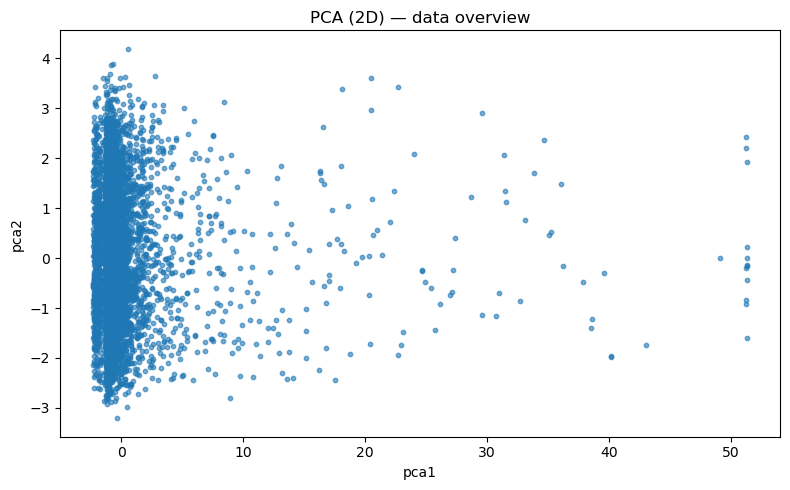

In [7]:

from sklearn.decomposition import PCA

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca2.fit_transform(X)
df_work["pca1"] = X_2d[:, 0]
df_work["pca2"] = X_2d[:, 1]

fig = plt.figure()
plt.scatter(df_work["pca1"], df_work["pca2"], s=10, alpha=0.6)
plt.title("PCA (2D) — data overview")
plt.xlabel("pca1"); plt.ylabel("pca2")
plt.tight_layout()
plt.show()



## 5. KMeans
We scan **k = 2..10** and track **Silhouette**, **Calinski–Harabasz**, **Davies–Bouldin**, and inertia (elbow). We choose `k` with strong Silhouette and an elbow in inertia.


,algo,param,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,kmeans,k=2,2,0.824012,5164.363723,0.508134
1,kmeans,k=3,3,0.635850,3792.948352,0.675211
2,kmeans,k=4,4,0.120194,2993.473641,1.693881
3,kmeans,k=5,5,0.124818,2635.691648,1.561552
4,kmeans,k=6,6,0.092216,2271.045206,1.859932
5,kmeans,k=7,7,0.094275,2025.478180,1.628354
6,kmeans,k=8,8,0.094308,1851.716132,1.775108
7,kmeans,k=9,9,0.107064,1724.325680,1.759682
8,kmeans,k=10,10,0.113287,1623.186812,1.745020


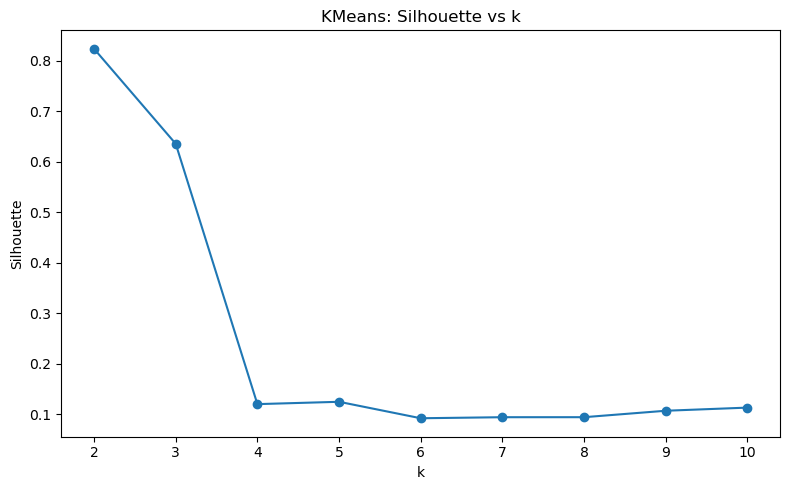

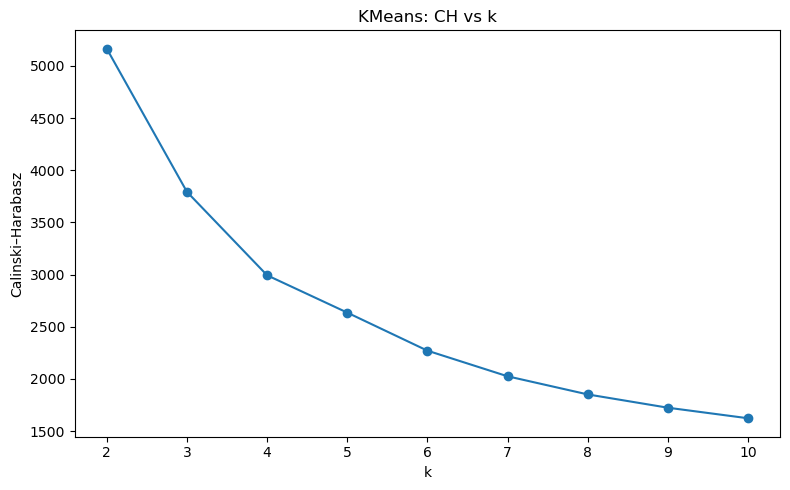

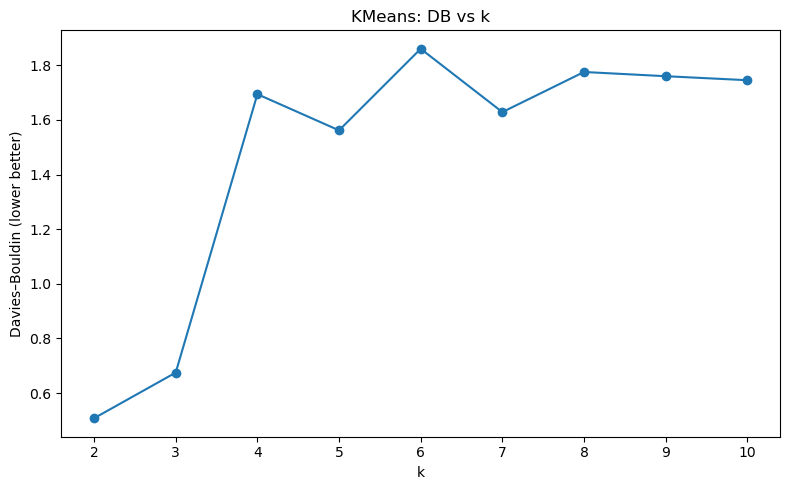

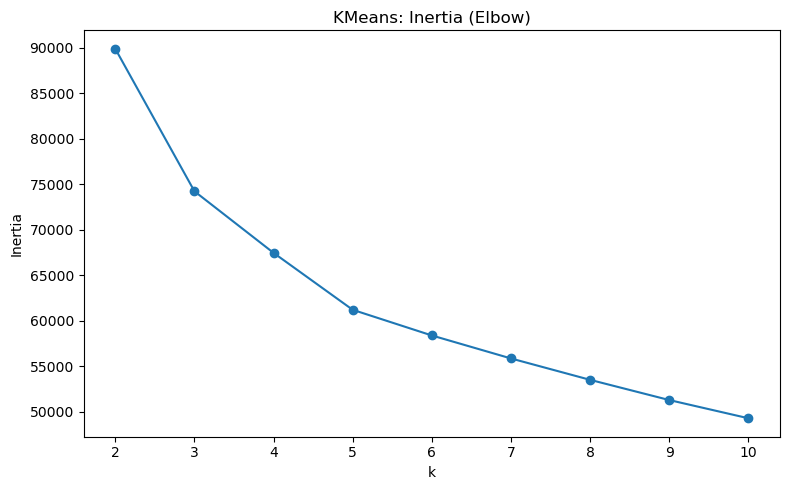

Chosen k for KMeans by Silhouette: 2


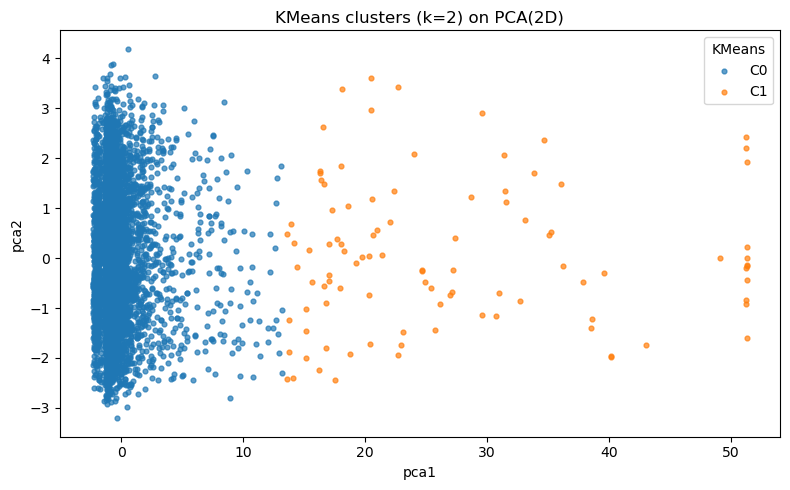

In [8]:

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k_range = range(2, 11)
km_rows = []
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    sil, ch, db = quality_indices(X, labels)
    inertias.append(km.inertia_)
    km_rows.append({"algo": "kmeans", "param": f"k={k}", "n_clusters": len(np.unique(labels)), 
                    "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})

km_df = pd.DataFrame(km_rows)
display(km_df)

# Plots (one figure each)
fig = plt.figure()
plt.plot(list(k_range), [r["silhouette"] for r in km_rows], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("KMeans: Silhouette vs k"); plt.tight_layout(); plt.show()

fig = plt.figure()
plt.plot(list(k_range), [r["calinski_harabasz"] for r in km_rows], marker="o")
plt.xlabel("k"); plt.ylabel("Calinski–Harabasz"); plt.title("KMeans: CH vs k"); plt.tight_layout(); plt.show()

fig = plt.figure()
plt.plot(list(k_range), [r["davies_bouldin"] for r in km_rows], marker="o")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin (lower better)"); plt.title("KMeans: DB vs k"); plt.tight_layout(); plt.show()

fig = plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("KMeans: Inertia (Elbow)"); plt.tight_layout(); plt.show()

# Choose best k by max Silhouette (tie-break by lower DB)
best_row = km_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]
best_k = int(best_row["param"].split("=")[1])
print("Chosen k for KMeans by Silhouette:", best_k)

km_final = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
df_work["cluster_kmeans"] = km_final.fit_predict(X)

# Visualize clusters in 2D PCA
fig = plt.figure()
for c in sorted(df_work["cluster_kmeans"].unique()):
    m = df_work["cluster_kmeans"] == c
    plt.scatter(df_work.loc[m, "pca1"], df_work.loc[m, "pca2"], s=12, alpha=0.7, label=f"C{c}")
plt.legend(title="KMeans")
plt.title(f"KMeans clusters (k={best_k}) on PCA(2D)")
plt.xlabel("pca1"); plt.ylabel("pca2")
plt.tight_layout(); plt.show()



## 6. Agglomerative (Hierarchical) Clustering
We test **linkages**: `ward`, `complete`, `average`. We try cluster counts around the KMeans choice to maintain comparability. We also plot a **dendrogram** (on a sample if needed) to visualize the hierarchy.


,algo,param,n_clusters,silhouette,calinski_harabasz,davies_bouldin
4,agg_average,k=2,2,0.874464,3587.356960,0.288342
5,agg_average,k=3,3,0.752325,3471.787546,0.551306
2,agg_complete,k=2,2,0.873659,3653.460020,0.292361
3,agg_complete,k=3,3,0.740778,3558.080517,0.556437
0,agg_ward,k=2,2,0.864464,4228.967004,0.337724
1,agg_ward,k=3,3,0.645963,3778.530576,0.659613


Chosen Agglomerative: average , k= 2


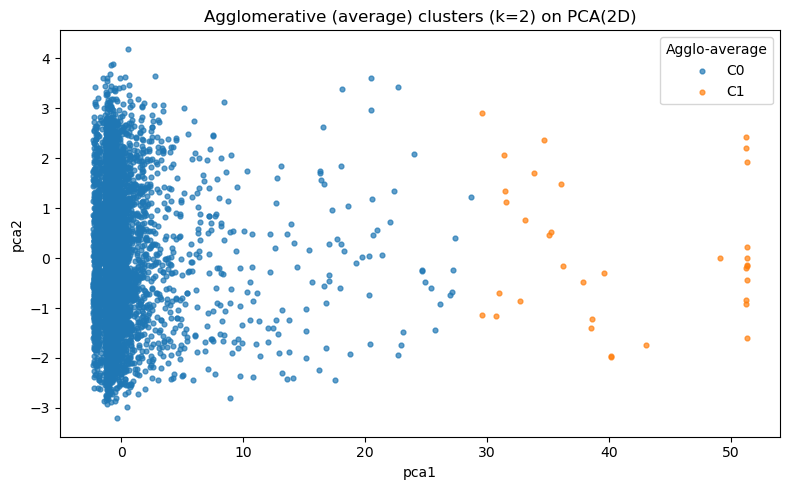

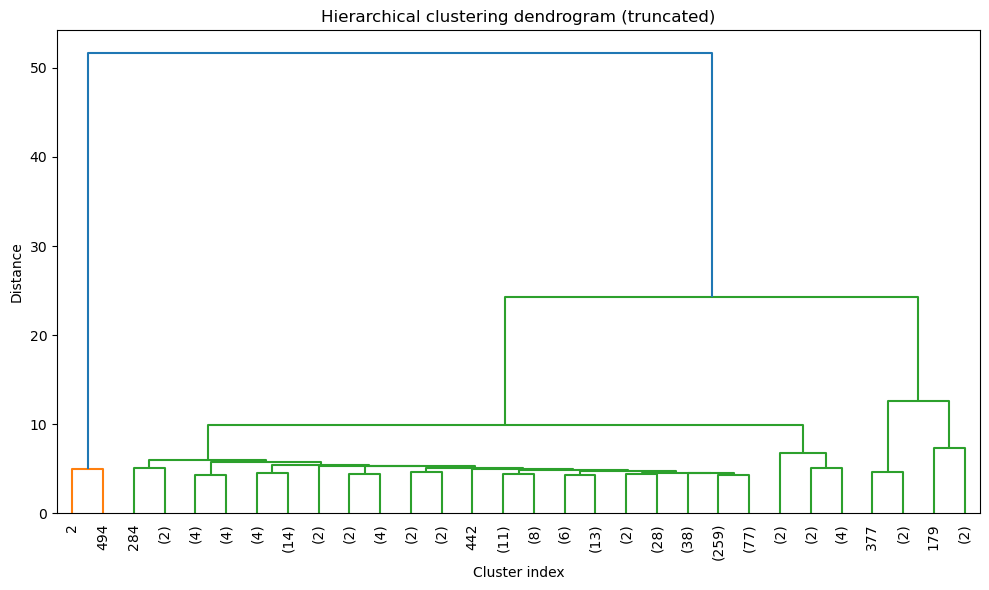

In [9]:

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

linkages = ["ward", "complete", "average"]
k_try = sorted(set([max(2, best_k-1), best_k, best_k+1]))
agg_rows = []

for link in linkages:
    for k in k_try:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage=link)
            labels = agg.fit_predict(X)
            sil, ch, db = quality_indices(X, labels)
            agg_rows.append({"algo": f"agg_{link}", "param": f"k={k}", "n_clusters": len(np.unique(labels)),
                             "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})
        except Exception as e:
            agg_rows.append({"algo": f"agg_{link}", "param": f"k={k}", "n_clusters": np.nan,
                             "silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan})

agg_df = pd.DataFrame(agg_rows)
display(agg_df.sort_values(["algo", "silhouette"], ascending=[True, False]))

# Choose best (highest Silhouette, then lowest DB)
best_agg = agg_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]
best_link = best_agg["algo"].split("_", 1)[1]
best_agg_k = int(best_agg["param"].split("=")[1])
print("Chosen Agglomerative:", best_link, ", k=", best_agg_k)

agg_final = AgglomerativeClustering(n_clusters=best_agg_k, linkage=best_link)
df_work["cluster_agglo"] = agg_final.fit_predict(X)

# Visualize
fig = plt.figure()
for c in sorted(df_work["cluster_agglo"].unique()):
    m = df_work["cluster_agglo"] == c
    plt.scatter(df_work.loc[m, "pca1"], df_work.loc[m, "pca2"], s=12, alpha=0.7, label=f"C{c}")
plt.legend(title=f"Agglo-{best_link}")
plt.title(f"Agglomerative ({best_link}) clusters (k={best_agg_k}) on PCA(2D)")
plt.xlabel("pca1"); plt.ylabel("pca2")
plt.tight_layout(); plt.show()

# Dendrogram (may be expensive on very large datasets) - sample if needed
sample_n = min(500, len(df_work))
idx = np.random.RandomState(42).choice(len(df_work), size=sample_n, replace=False)
Z = linkage(X[idx], method=best_link if best_link != "ward" else "ward")
fig = plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90.)
plt.title("Hierarchical clustering dendrogram (truncated)")
plt.xlabel("Cluster index"); plt.ylabel("Distance")
plt.tight_layout(); plt.show()



## 7. DBSCAN (density-based)
- Detects arbitrarily shaped clusters; **labels noise as -1**.
- We use a **k-distance plot** as a heuristic to pick `eps`, and grid over a few candidates.
- `min_samples` is set based on dimensionality and sample size (default 10 here).


DBSCAN eps candidates: [2.6798094499952563, 3.0269082657111572, 3.7428985630073077]  (min_samples= 10 )


,algo,param,n_clusters,silhouette,calinski_harabasz,davies_bouldin,noise_frac
0,dbscan,eps=2.680,2,0.547123,138.152598,0.602717,0.043011
1,dbscan,eps=3.027,1,NaN,NaN,NaN,0.025300
2,dbscan,eps=3.743,1,NaN,NaN,NaN,0.011860


Chosen DBSCAN eps=2.680 | noise fraction=4.3%


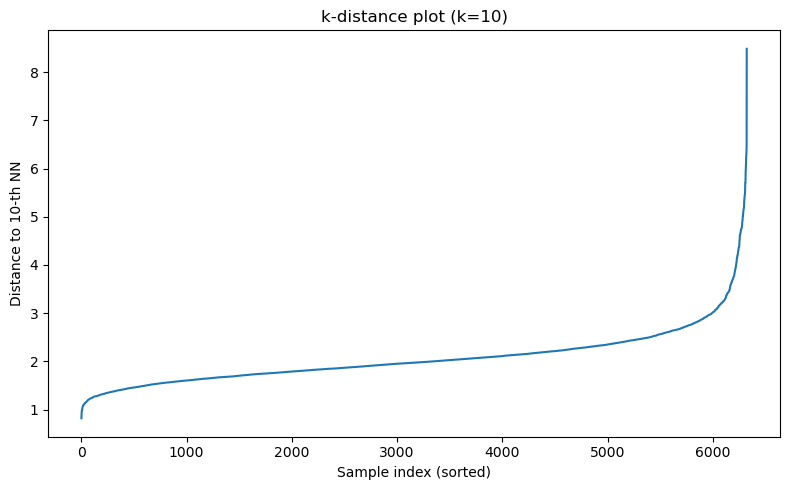

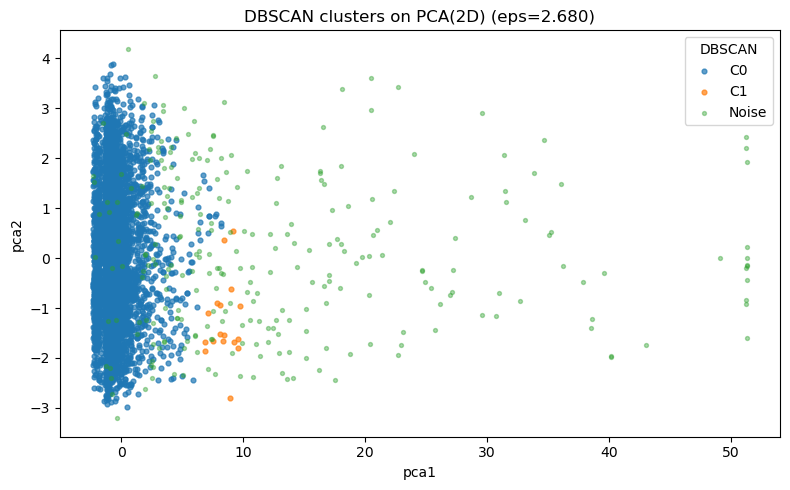

In [10]:

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

min_samples = max(10, int(0.5 * X.shape[1]))  # simple heuristic
k_dists = plot_knee_kdist(X, k=min_samples)

# Try a few eps values around upper quantiles of the k-distances
cands = []
for q in [0.90, 0.95, 0.98]:
    cands.append(float(np.quantile(k_dists, q)))
eps_candidates = sorted(set(cands))
print("DBSCAN eps candidates:", eps_candidates, " (min_samples=", min_samples, ")")

db_rows = []
db_best = {"silhouette": -np.inf}

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Compute metrics on non-noise points if > 1 cluster
    mask = labels != -1
    if n_clusters >= 2 and mask.sum() > 1:
        sil, ch, dbi = quality_indices(X[mask], labels[mask])
    else:
        sil, ch, dbi = (np.nan, np.nan, np.nan)
    noise_frac = float((labels == -1).mean())
    db_rows.append({"algo": "dbscan", "param": f"eps={eps:.3f}", "n_clusters": n_clusters,
                    "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": dbi, "noise_frac": noise_frac})
    # Track best
    if np.isfinite(sil) and sil > db_best.get("silhouette", -np.inf):
        db_best = {"eps": eps, "labels": labels, "silhouette": sil, "noise_frac": noise_frac}

db_df = pd.DataFrame(db_rows)
display(db_df)

if "labels" in db_best:
    df_work["cluster_dbscan"] = db_best["labels"]
    eps_best = db_best["eps"]
    noise_frac = db_best["noise_frac"]
    print(f"Chosen DBSCAN eps={eps_best:.3f} | noise fraction={noise_frac:.1%}")
    # Visualize non-noise labels
    fig = plt.figure()
    uniq = sorted(set(df_work["cluster_dbscan"]) - {-1})
    for c in uniq:
        m = df_work["cluster_dbscan"] == c
        plt.scatter(df_work.loc[m, "pca1"], df_work.loc[m, "pca2"], s=12, alpha=0.7, label=f"C{c}")
    if (-1 in set(df_work["cluster_dbscan"])):
        m = df_work["cluster_dbscan"] == -1
        plt.scatter(df_work.loc[m, "pca1"], df_work.loc[m, "pca2"], s=8, alpha=0.4, label="Noise")
    plt.legend(title="DBSCAN")
    plt.title(f"DBSCAN clusters on PCA(2D) (eps={eps_best:.3f})")
    plt.xlabel("pca1"); plt.ylabel("pca2")
    plt.tight_layout(); plt.show()
else:
    df_work["cluster_dbscan"] = -1
    print("DBSCAN did not find multiple clusters with the heuristic eps values.")



## 8. Evaluation Summary (Silhouette / DB / CH)
We consolidate metrics across algorithms to pick a **winner** for profiling.


In [11]:

import pandas as pd
import numpy as np

eval_frames = []
if "km_df" in globals(): eval_frames.append(km_df.copy())
if "agg_df" in globals(): eval_frames.append(agg_df.copy())
if "db_df" in globals(): eval_frames.append(db_df.copy())

eval_full = pd.concat([e for e in eval_frames if len(e)], ignore_index=True)

# unify columns
if "noise_frac" not in eval_full.columns:
    eval_full["noise_frac"] = np.nan

# Summarize best by Silhouette
winner = eval_full.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]
print("=== Winner by Silhouette ===")
display(winner.to_frame().T)

eval_csv = OUT_DIR / "cluster_eval.csv"
eval_full.to_csv(eval_csv, index=False)
print("Saved:", eval_csv)

display(eval_full.sort_values("silhouette", ascending=False).head(10))


=== Winner by Silhouette ===


,algo,param,n_clusters,silhouette,calinski_harabasz,davies_bouldin,noise_frac
13,agg_average,k=2,2,0.874464,3587.35696,0.288342,NaN


Saved: /Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/cluster_eval.csv


,algo,param,n_clusters,silhouette,calinski_harabasz,davies_bouldin,noise_frac
13,agg_average,k=2,2,0.874464,3587.356960,0.288342,NaN
11,agg_complete,k=2,2,0.873659,3653.460020,0.292361,NaN
9,agg_ward,k=2,2,0.864464,4228.967004,0.337724,NaN
0,kmeans,k=2,2,0.824012,5164.363723,0.508134,NaN
14,agg_average,k=3,3,0.752325,3471.787546,0.551306,NaN
12,agg_complete,k=3,3,0.740778,3558.080517,0.556437,NaN
10,agg_ward,k=3,3,0.645963,3778.530576,0.659613,NaN
1,kmeans,k=3,3,0.635850,3792.948352,0.675211,NaN
15,dbscan,eps=2.680,2,0.547123,138.152598,0.602717,0.043011
3,kmeans,k=5,5,0.124818,2635.691648,1.561552,NaN



## 9. Cluster Profiling (winner)
We interpret the best-performing clusters with domain-relevant summaries:
- **Size & composition**: counts per cluster
- **Price & size**: mean/median `price`, `size_sqm`, `price_per_sqm`, `rooms`
- **Location mix**: top neighborhoods/cities per cluster
- **Amenities**: average presence of binary features (elevator, AC, etc.) if available


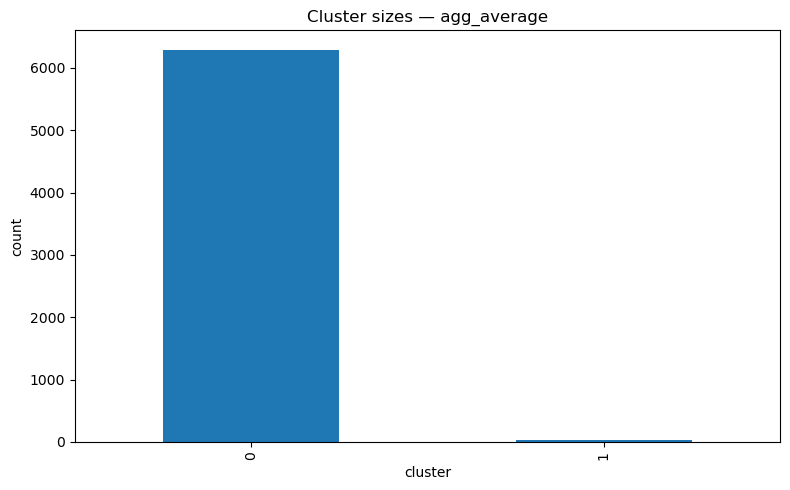

,cluster,price_mean,price_median,size_sqm_mean,size_sqm_median,rooms_mean,rooms_median,price_per_sqm_mean,price_per_sqm_median,floor_ratio_mean,...,wheelchair_access_rate,tornado_ac_rate,multi_bolt_doors_rate,air_conditioning_rate,bars_rate,storage_rate,solar_water_heater_rate,renovated_rate,mamad_rate,top_neighborhoods
0,0,6748.006678,6000.0,85.200509,80.0,3.239068,3.0,83.597664,75.555556,0.625303,...,0.323104,0.296391,0.505963,0.947209,0.266974,0.163301,0.665766,0.542376,0.322786,Unknown (9%); הצפון הישן - צפון (4%); פלורנטין...
1,1,7683.657143,7400.0,78.800000,70.0,2.885714,3.0,107.030810,100.000000,0.625796,...,0.685714,0.228571,0.285714,0.971429,0.257143,0.342857,0.457143,0.828571,0.428571,כרם התימנים (17%); Unknown (11%); הגבול רוטשיל...


/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_11134/1634351971.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(cid) for cid in sorted(df_work[label_col].dropna().unique())])


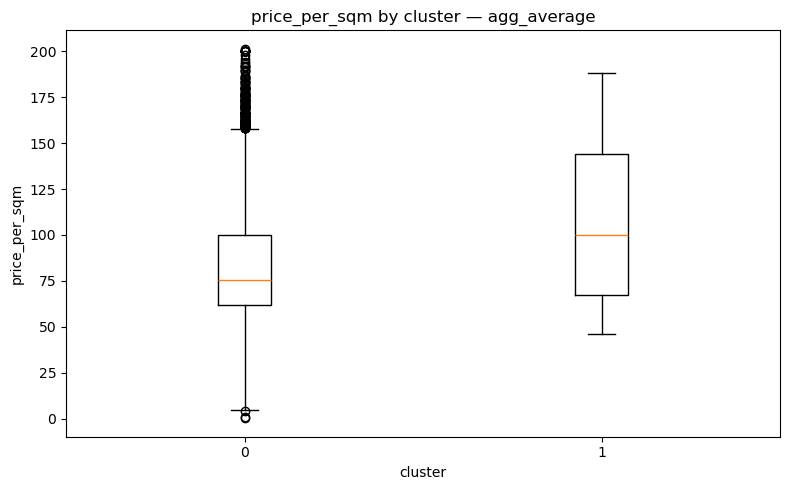

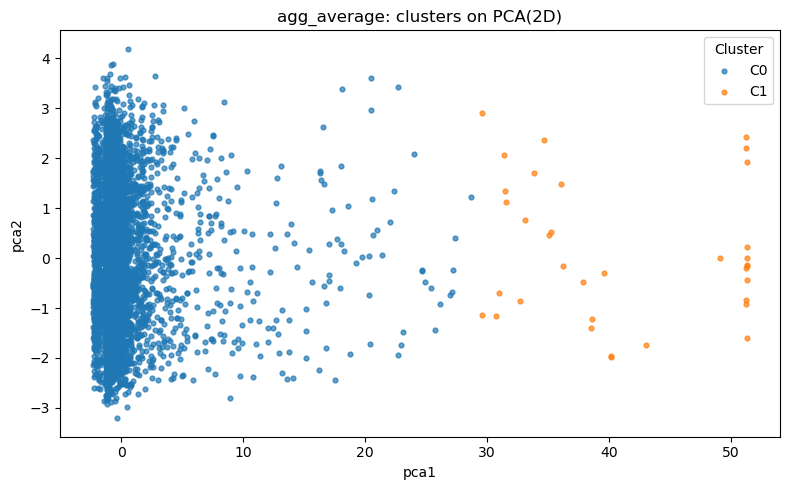

Saved clustered data: /Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/clustered_realestate.csv
Saved profiles: /Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/cluster_profiles.csv


In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine label column of the winner
algo = str(winner["algo"])
label_col = None
if algo == "kmeans":
    label_col = "cluster_kmeans"
elif algo.startswith("agg_"):
    label_col = "cluster_agglo"
elif algo == "dbscan":
    label_col = "cluster_dbscan"

if label_col is None or label_col not in df_work.columns:
    raise RuntimeError("Winner algorithm labels not found in df_work.")

# Basic composition
comp = df_work[label_col].value_counts(dropna=False).sort_index()
fig = plt.figure()
comp.plot(kind="bar")
plt.title(f"Cluster sizes — {algo}")
plt.xlabel("cluster"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Numeric summaries
num_cols = [c for c in ["price","size_sqm","rooms","price_per_sqm","floor_ratio","days_since_published"] if c in df_work.columns]
prof = df_work.groupby(label_col)[num_cols].agg(["mean","median","std","min","max","count"])

# Amenities (booleans)
amenities = [c for c in ["elevator","wheelchair_access","tornado_ac","multi_bolt_doors","air_conditioning",
                         "bars","storage","solar_water_heater","renovated","mamad"] if c in df_work.columns]
amen_prof = None
if amenities:
    amen_prof = df_work.groupby(label_col)[amenities].mean()

# Locations
loc_df = None
if "neighborhood" in df_work.columns:
    loc_df = df_work.groupby(label_col)["neighborhood"].apply(top_categories)

# Combine profiles
profile_lines = []
for cid in sorted(df_work[label_col].dropna().unique()):
    row = {"cluster": cid}
    if num_cols:
        for c in num_cols:
            row[f"{c}_mean"] = df_work.loc[df_work[label_col]==cid, c].mean()
            row[f"{c}_median"] = df_work.loc[df_work[label_col]==cid, c].median()
    if amenities:
        for a in amenities:
            row[f"{a}_rate"] = df_work.loc[df_work[label_col]==cid, a].astype(float).mean()
    if "neighborhood" in df_work.columns:
        row["top_neighborhoods"] = top_categories(df_work.loc[df_work[label_col]==cid, "neighborhood"], topn=3)
    profile_lines.append(row)

profiles = pd.DataFrame(profile_lines).sort_values("cluster")
display(profiles)

# Boxplot: price_per_sqm by cluster (if available)
if "price_per_sqm" in df_work.columns:
    fig = plt.figure()
    groups = [df_work.loc[df_work[label_col]==cid, "price_per_sqm"].dropna().values 
              for cid in sorted(df_work[label_col].dropna().unique())]
    plt.boxplot(groups, labels=[str(cid) for cid in sorted(df_work[label_col].dropna().unique())])
    plt.title(f"price_per_sqm by cluster — {algo}")
    plt.xlabel("cluster"); plt.ylabel("price_per_sqm")
    plt.tight_layout(); plt.show()

# PCA scatter colored by cluster
fig = plt.figure()
uniq = sorted(df_work[label_col].dropna().unique())
for cid in uniq:
    m = df_work[label_col] == cid
    plt.scatter(df_work.loc[m, "pca1"], df_work.loc[m, "pca2"], s=12, alpha=0.7, label=f"C{cid}")
plt.legend(title="Cluster")
plt.title(f"{algo}: clusters on PCA(2D)")
plt.xlabel("pca1"); plt.ylabel("pca2")
plt.tight_layout(); plt.show()

# Persist artifacts
clustered_csv = OUT_DIR / "clustered_realestate.csv"
df_work.to_csv(clustered_csv, index=False)
print("Saved clustered data:", clustered_csv)

profiles_csv = OUT_DIR / "cluster_profiles.csv"
profiles.to_csv(profiles_csv, index=False)
print("Saved profiles:", profiles_csv)



## 10. Justifications & Next Steps

**Preprocessing choices**
- **RobustScaler** reduces the influence of extreme values (common in real-estate prices).
- **Feature engineering** (`price_per_sqm`, `floor_ratio`, `is_top_floor`) captures normalized value, vertical position, and special cases that matter for price/appeal.
- **Embedding PCA (optional)** adds semantics from the listing description while keeping dimensionality manageable.

**Model choices**
- **KMeans** baseline: fast, reliable for convex clusters.
- **Agglomerative**: exposes a hierarchy and can better fit non-spherical cluster boundaries than KMeans; dendrogram aids interpretation.
- **DBSCAN**: detects arbitrarily shaped clusters and **noise**, good for discovering rare/atypical listing groups without pre-setting `k`.

**Evaluation**
- We compare **Silhouette** (cohesion/separation), **Davies–Bouldin** (lower is better), and **Calinski–Harabasz** (higher is better).
- Selecting the winner by highest Silhouette (tie-break with DB) is a standard, defensible heuristic for unsupervised tasks.

**Interpretability**
- Cluster profiles aggregate key numerics, location mix, and amenity rates so stakeholders can describe each cluster in plain language.

**Next steps (optional)**
- **Stability checks**: re-fit with different seeds / bootstrapping and examine label stability (e.g., ARI between runs).
- **Geography-aware distance**: if lat/long is available, use Haversine or add spatial regularization.
- **Anomaly detection** (alternative track): IsolationForest / LocalOutlierFactor, and sigma-rule on residuals from a price model.
- **Downstream use**: price calibration per cluster, personalized recommendations using cluster neighborhoods in embedding space.
